## Collaborative Filtering Recommenders 
Aim: 
> to **more accurately** recomend company with new custmers of potential high spendings in the company 

By : 
> exploring different rating design (considering **number of purchases**); change **simialrity measure** in CF



### Summary of I/O csv files

Input Files
    > "train_dol.txt"     - all company-customer level spendings in training period
    > "test_dol.txt"      - potential customers with actual spendings in testing period for company 36
    > "train_dol_log.txt" - log transformed
    > "test_dol_log.txt"  - log transformed
    > "train_num.txt"     - all company-customer level #purchases in training period
    > "test_num.txt"      - potential customers with actual #purchases in testing period for company 36
    > "train_num_log.txt" - log transformed
    > "test_num_log.txt"  - log transformed

Output Files

    > Results and summary for svd, "summary_" 
    'cf_further_svd_dol.csv',
    'cf_further_svd_dol_log.csv',
    'cf_further_svd_num.csv',
    'cf_further_svd_num_log.csv',
    > Results and summary for knn, "summary_" 
    'knn_company_36_dol_log_sim_cosine.csv',
    'knn_company_36_dol_log_sim_msd.csv',
    'knn_company_36_dol_log_sim_pearson_baseline.csv',
    'knn_company_36_dol_sim_cosine.csv',
    'knn_company_36_dol_sim_msd.csv',
    'knn_company_36_dol_sim_pearson_baseline.csv',
    'knn_company_36_num_log_sim_cosine.csv',
    'knn_company_36_num_log_sim_msd.csv',
    'knn_company_36_num_log_sim_pearson.csv',
    'knn_company_36_num_log_sim_pearson_baseline.csv',
    'knn_company_36_num_sim_cosine.csv',
    'knn_company_36_num_sim_msd.csv',
    'knn_company_36_num_sim_pearson_baseline.csv'

### Part 1: Use different r_ui
    Aim: improve on current best reuslt (svd_dol_log)
    By constructing worthiness score (rating by company for customer) with number of purchases (i.e. svd_num, svd_num_log)

In [ ]:
import pandas as pd
from surprise import Dataset                                                      
from surprise import Reader                                                      
from surprise import SVD
from surprise.accuracy import rmse

reader = Reader(line_format='user item rating', sep='\t')
measures = ["dol", "dol_log", "num", "num_log"] 

for measure in measures:
    print("\nMeasure:", measure)
    train_file = "train_"+ measure +".txt"
    test_file = "test_"+ measure +".txt"
    data = Dataset.load_from_folds([(train_file, test_file)], reader=reader)   
    for trainset, testset in data.folds():
        try:        
            algo = SVD()                                                    
            algo.train(trainset)                             
            predictions = algo.test(testset) # uid, iid, r_ui, est, details
            rmse(predictions)
            results_df = pd.DataFrame.from_dict(predictions)
            print("Range of est:",max(results_df.est), min(results_df.est))
            print(results_df[results_df.iid=='343'])
            file_name = "cf_further_svd_"+measure+".csv"
            results_df.to_csv(file_name, index=False)
        except:
            pass


Measure: dol
RMSE: 9.9993
Range of est: 5 5
    uid  iid  r_ui  est                    details
269  36  343  28.0    5  {'was_impossible': False}

Measure: dol_log
RMSE: 3.7073
Range of est: 5.0 2.35882129778
    uid  iid      r_ui       est                    details
269  36  343  3.332205  3.546063  {'was_impossible': False}

Measure: num
RMSE: 1.2243
Range of est: 5.0 1.0
    uid  iid  r_ui  est                    details
269  36  343   1.0  1.0  {'was_impossible': False}

Measure: num_log
RMSE: 0.9993
Range of est: 1.33778446945 1.0
    uid  iid  r_ui  est                    details
269  36  343   0.0  1.0  {'was_impossible': False}


In [1]:
## use dol as reference, as it contains actual dollar in testing period, which is p-hat-ui
df = pd.read_csv('cf_further_svd_dol.csv')
df = df [["iid","r_ui"]]
df.columns = [['HH_ID', 'ActualRevenue']] # actual dollar in testing period

In [8]:
"""summary: get data for acquisition profitability  graph & save csv decile summary"""
list_ = [] # container to place results_df
measures = ["dol", "dol_log", "num", "num_log"] 

for measure in measures:
    file_name = "cf_further_svd_"+measure+".csv"
    results_df = pd.read_csv(file_name) 
    # only need 2 columns: customer id and estimated score, r-hat-ui
    results_df = results_df[["iid", "est"]]
    results_df.columns = ['HH_ID', 'Score']
    # merge with actual dollar in testing period, which is p-hat-ui
    result = pd.merge(results_df, df[['HH_ID', 'ActualRevenue']], on='HH_ID')
    # assign mean to group of the same score, "ActualRevenueMean"
    results_df = result.join(result.groupby('Score')['ActualRevenue'].mean(), on='Score', rsuffix='Mean')    
    # Output append to list_
    list_.append(results_df[['HH_ID',"ActualRevenueMean"]].reset_index(drop=True))
    # get 10 lines for decile description
    results_df = results_df.sort_values(by="Score",ascending=False).reset_index(drop=True)
    quant = [0,10,20,30,40,50,60,70,80,90,100]
    quant_est = np.percentile(results_df.index,quant)
    groups =  results_df.groupby(pd.cut(results_df.index, quant_est, include_lowest=True))
    df4 = groups.agg({"HH_ID": 'count', 'Score': 'mean', "ActualRevenue":'mean', "ActualRevenueMean":'mean'})
    df4["percentile"] = quant[1:]
    df4 = df4[["percentile", "HH_ID","Score","ActualRevenue","ActualRevenueMean"]]    
    # Summary to csv
    df4.to_csv("summary_"+file_name, index=False)

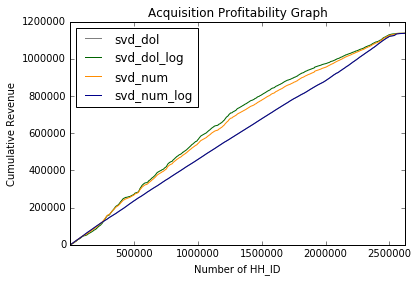

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
i = 0
for file in list_: 
    measure = measures[i]
    file.columns = [["HH_ID","svd_"+measure]]
    file.set_index("HH_ID", drop=True, inplace=True)
    i+=1
graph = pd.concat(list_, axis=1)
graph = graph.cumsum() ## (Actual Revenue Mean)
color = ['Red','DarkGreen','DarkOrange','DarkBlue',]
graph.plot(color=color, title='Acquisition Profitability Graph')
plt.xlabel('Number of HH_ID')
plt.ylabel('Cumulative Revenue')
plt.savefig("svd_diff_score_acquisition_profitability_curve.jpeg")

### Coclusion:
Observed trend: svd_dol and svd_num_log are very close to each other; svd_dol_log still outperforms the others

### Part 2: Use different similarity
    Aim: improve on current fastest algorthims reuslt (kNN), which is also the only one use similarity
    By explorating the algorithms in detail  
#### change sim_options
    name: msd = Mean Squared Difference; cosine; pearson; pearson_baseline = baselines for centering shrunk by 100
    'user_based' default True and not changed, else for 2.5M items(customer), incure *memory error at sim = construction_func[name](*args)*
#### not change bsl_options not changed 
    method:  default 'als' (Alternating Least Squares) better for sparse data than 'sgd'(Stochastic Gradient Descent)
    Aberger, C. R. Recommender: An Analysis of Collaborative Filtering Techniques. Retrived from http://cs229.stanford.edu/proj2014/Christopher%20Aberger,%20Recommender.pdf    

In [ ]:
"""knn for different similarity measure for core being dol, dol_log, num, num_log"""
import pandas as pd

from surprise import Dataset                                                      
from surprise import Reader                                                      
from surprise import KNNBasic
from surprise.accuracy import rmse

reader = Reader(line_format='user item rating', sep='\t')
measures = ["dol", "dol_log", "num", "num_log"]
name = ["msd","cosine","pearson","pearson_baseline"]

for measure in measures:
    print("\nMeasure:", measure)
    train_file = "train_"+ measure +".txt"
    test_file = "test_"+ measure +"_company_36.txt"
    data = Dataset.load_from_folds([(train_file, test_file)], reader=reader)   
    for trainset, testset in data.folds():
        for name_option in name:
            try:
                sim_options = {'name': name_option}        
                print("\n","Sim measure:",sim_options)        
                algo = KNNBasic(sim_options=sim_options)                                                    
                algo.train(trainset)                             
                predictions = algo.test(testset)
                rmse(predictions)
                results_df = pd.DataFrame.from_dict(predictions)
                print("Range of est:",max(results_df.est), min(results_df.est))
                print(results_df[results_df.iid=='343'])
                file_name = "knn_company_36_"+measure+"_sim_"+name_option+".csv"
                results_df.to_csv(file_name, index=False)				
            except:
                pass

In [ ]:
#Results obtained from runing above cell as python file in command line overnight
"""
Measure: dol

 Sim measure: {'name': 'msd'}
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 9.9981
Range of est: 5.0 1.0
    uid  iid  r_ui  est                                   details
269  36  343  28.0  5.0  {'actual_k': 5, 'was_impossible': False}

 Sim measure: {'name': 'cosine'}
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 9.9981
Range of est: 5.0 1.0
    uid  iid  r_ui  est                                   details
269  36  343  28.0  5.0  {'actual_k': 2, 'was_impossible': False}

 Sim measure: {'name': 'pearson'}
Computing the pearson similarity matrix...

 Sim measure: {'name': 'pearson_baseline'}
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 9.9989
Range of est: 5.0 1.0
    uid  iid  r_ui  est                                   details
269  36  343  28.0  5.0  {'actual_k': 1, 'was_impossible': False}


Measure: dol_log

 Sim measure: {'name': 'msd'}
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 4.3426
Range of est: 5.0 1.0
    uid  iid      r_ui       est                                   details
269  36  343  3.332205  3.451028  {'actual_k': 5, 'was_impossible': False}

 Sim measure: {'name': 'cosine'}
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 4.4299
Range of est: 5.0 1.0
    uid  iid      r_ui      est                                   details
269  36  343  3.332205  2.70805  {'actual_k': 1, 'was_impossible': False}

 Sim measure: {'name': 'pearson'}
Computing the pearson similarity matrix...

 Sim measure: {'name': 'pearson_baseline'}
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 4.4357
Range of est: 5.0 1.0
    uid  iid      r_ui  est                                   details
269  36  343  3.332205  5.0  {'actual_k': 1, 'was_impossible': False}



Measure: num

 Sim measure: {'name': 'msd'}
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 2.0604
Range of est: 5.0 1.0
    uid  iid  r_ui       est                                   details
269  36  343   1.0  1.886718  {'actual_k': 5, 'was_impossible': False}

 Sim measure: {'name': 'cosine'}
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 2.1588
Range of est: 5.0 1.0
    uid  iid  r_ui  est                                   details
269  36  343   1.0  1.0  {'actual_k': 1, 'was_impossible': False}

 Sim measure: {'name': 'pearson'}
Computing the pearson similarity matrix...

 Sim measure: {'name': 'pearson_baseline'}
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 2.1386
Range of est: 5.0 1.0
    uid  iid  r_ui  est                                   details
269  36  343   1.0  5.0  {'actual_k': 1, 'was_impossible': False}




Measure: num_log

 Sim measure: {'name': 'msd'}
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0706
Range of est: 5.0 1.0
    uid  iid  r_ui  est                                   details
269  36  343   0.0  1.0  {'actual_k': 5, 'was_impossible': False}

 Sim measure: {'name': 'cosine'}
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0750
Range of est: 5.0 1.0
    uid  iid  r_ui  est                                   details
269  36  343   0.0  1.0  {'actual_k': 5, 'was_impossible': False}

 Sim measure: {'name': 'pearson'}
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0764
Range of est: 5.0 1.0
    uid  iid  r_ui  est                                   details
269  36  343   0.0  1.0  {'actual_k': 5, 'was_impossible': False}

 Sim measure: {'name': 'pearson_baseline'}
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0143
Range of est: 4.56434819147 1.0
    uid  iid  r_ui       est                                   details
269  36  343   0.0  2.079442  {'actual_k': 1, 'was_impossible': False}
"""

In [9]:
"""summary: save csv decile summary (with mean in each decile as "ActualRevenueMean")""" 
import os
allFiles = [f for f in os.listdir('.') if( (os.path.isfile(f) and ("knn_company_36_" in f) and ("summary" not in f)))]
for file_name in allFiles:
    results_df = pd.read_csv(file_name)
    # only need 2 columns: customer id and estimated score, r-hat-ui
    results_df = results_df[["iid", "est"]]
    results_df = results_df.sort_values(by="est", ascending=False).reset_index(drop=True)
    results_df.columns = ['HH_ID', 'Score']
    # merge with actual dollar in testing period, which is p-hat-ui
    results_df = pd.merge(results_df, df[['HH_ID', 'ActualRevenue']], on='HH_ID')
    # assign mean to group of the same score, "ActualRevenueMean"
    results_df = results_df.join(results_df.groupby('Score')['ActualRevenue'].mean(), on='Score', rsuffix='Mean')
    results_df = results_df.sort_values(by="Score",ascending=False).reset_index(drop=True)
    # get 10 lines for decile description
    quant = [0,10,20,30,40,50,60,70,80,90,100]
    quant_est = np.percentile(results_df.index,quant)
    groups =  results_df.groupby(pd.cut(results_df.index, quant_est, include_lowest=True))
    df4 = groups.agg({"HH_ID": 'count', 'Score': 'mean', "ActualRevenue":'mean', "ActualRevenueMean":'mean'})
    df4["percentile"] = quant[1:]
    df4 = df4[["percentile", "HH_ID","Score","ActualRevenue","ActualRevenueMean"]] 
    output_name = "summary_"+file_name
    df4.to_csv(output_name, index=False)
    print(output_name)

summary_knn_company_36_dol_log_sim_cosine.csv
summary_knn_company_36_dol_log_sim_msd.csv
summary_knn_company_36_dol_log_sim_pearson_baseline.csv
summary_knn_company_36_dol_sim_cosine.csv
summary_knn_company_36_dol_sim_msd.csv
summary_knn_company_36_dol_sim_pearson_baseline.csv
summary_knn_company_36_num_log_sim_cosine.csv
summary_knn_company_36_num_log_sim_msd.csv
summary_knn_company_36_num_log_sim_pearson.csv
summary_knn_company_36_num_log_sim_pearson_baseline.csv
summary_knn_company_36_num_sim_cosine.csv
summary_knn_company_36_num_sim_msd.csv
summary_knn_company_36_num_sim_pearson_baseline.csv


## Detailed results can be viewed from the interactive charts in demo
> **knn_num_log_sim_cosine** is the best (highest mean p_ui for top 2 decile)